In [ ]:
from fastai import *
from fastai.tabular import *
from fastai.tabular.data import *

In [ ]:
import pandas as pd
from collections import Counter

path = './drive/MyDrive/Materiale_Pellegrino_personal/CTU_Shuffled/CTU_Shuffled.csv'
dataset = pd.read_csv(path)

In [ ]:
dataset

,StartTime,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,52:49.3,0.000540,1,<->,CON,0.0,0.0,2,131,71,flow=Background-UDP-Established,normal
1,58:54.5,0.014909,2,->,SRPA_FSPA,0.0,0.0,11,2882,1504,flow=Background-TCP-Established,normal
2,57:55.7,0.000798,1,<->,CON,0.0,0.0,2,244,182,flow=Background-UDP-Established,normal
3,56:16.4,15.302759,1,->,INT,0.0,NaN,4,336,336,flow=Background-UDP-Attempt,normal
4,53:17.7,7.843942,2,->,FSPA_SRPA,0.0,0.0,93,11846,4562,flow=Background-TCP-Established,normal
...,...,...,...,...,...,...,...,...,...,...,...,...
31468,00:19.1,8.917003,2,->,S_SA,0.0,0.0,8,512,194,flow=Background-TCP-Established,normal
31469,59:40.5,0.038780,1,<->,CON,0.0,0.0,2,191,68,flow=To-Background-UDP-CVUT-DNS-Server,normal
31470,58:04.2,603.106201,1,->,INT,0.0,NaN,6,552,552,flow=Background-Attempt-cmpgw-CVUT,normal
31471,00:22.8,0.000550,1,<->,CON,0.0,0.0,2,128,60,flow=Background-UDP-Established,normal


In [ ]:
print(Counter(dataset['multilabel']))

Counter({'normal': 31406, 'BotNet': 67})


### ***PRE-ELABORAZIONE DATI***

In [ ]:
dataset = dataset.drop('StartTime', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)


In [ ]:
print('Len train: ', len(train))
print('Len test: ', len(test))

Len train:  15736
Len test:  15737


In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder delle due variabili target, quindi da stringhe a interi sia in test che in train e salvo i valori nelle variabili y_test a y_train
# y_test viene utilizzata per la valutazione del modello

y_train = LabelEncoder().fit_transform(train['multilabel'])
y_test = LabelEncoder().fit_transform(test['multilabel'])


# sostituisco i valori originari con la codifica precedentemente fatta
target_index = train.columns.get_loc('multilabel')
train.iloc[:, target_index] = y_train

# elimino la colonna relativa al target nel dataset di test poiché non utile
test = test.drop('multilabel', axis=1)

In [ ]:
train.head()

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
14012,0.000909,1,<->,CON,0.0,0.0,2,543,77,flow=Background-UDP-Established,1
11765,129.030228,2,->,FSPA_FSPA,0.0,0.0,34,20099,3239,flow=Background-TCP-Established,1
14129,0.000000,1,->,INT,0.0,NaN,1,351,351,flow=Background-UDP-Attempt,1
7601,7.440065,2,->,FSPA_FSPA,0.0,0.0,12,3408,2049,flow=Background-TCP-Established,1
18277,20.086140,2,->,FSPA_FSPA,0.0,0.0,10,1634,1012,flow=To-Background-CVUT-Proxy,1


In [ ]:
test.head()

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
19292,605.798096,1,<->,CON,0.0,0.0,4,484,360,flow=Background-UDP-Established
19526,0.000412,1,<->,CON,0.0,0.0,2,571,74,flow=To-Background-UDP-CVUT-DNS-Server
725,0.423465,1,<->,CON,0.0,0.0,2,550,73,flow=Background-Established-cmpgw-CVUT
14894,0.000151,1,<->,CON,0.0,0.0,2,207,66,flow=To-Background-UDP-CVUT-DNS-Server
30022,1270.517334,1,<->,CON,0.0,0.0,391,117465,23844,flow=Background-UDP-Established


### ***MODEL***

In [ ]:
""" Definisco delle variabili utili al nostro modello per saper come trattare i dati. 
  Distinguendo variabile target, continue e categoriali. 
  Inoltre in procs vengono passati degli ottimizzatori che vengono applicati ai dati prima del training: in particolare con FillMissing vengono sostituiti
  eventuali valori NaN, Categorify si occupa di codificare le variabili categoriali e Normalize si occupa di normalizzare i valori continui."""

dep_var = 'multilabel'
cat_names = ["Dir", "State", "Details"]
cont_names = [col for col in train.columns if col not in cat_names and col != dep_var]
procs = [FillMissing, Categorify, Normalize]

print('Target: ', dep_var)
print('Cat: ', cat_names)
print('Cont: ', cont_names)

Target:  multilabel
Cat:  ['Dir', 'State', 'Details']
Cont:  ['Dur', 'Proto', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes']


In [ ]:
# Splitto il dataset in valid
from sklearn.model_selection import train_test_split

def SplitSet(df):
     train, valid = train_test_split(df, test_size=0.158871378)
     split_val = len(train)
     train = train.append(valid)
     return train, split_val

traindf, idx = SplitSet(train)

In [ ]:
# Lista da passare al nostro tabular learner per effettuare la fase di test
test = TabularList.from_df(test, cat_names= cat_names, cont_names=cont_names, procs=procs)

# Lista contenete gli insiemi di training e validation, necessari per l'addrestamento del modello
data = TabularList.from_df(traindf, cat_names= cat_names, cont_names=cont_names, procs=procs)
data = data.split_by_idx(list(range(idx, len(traindf))))
data = data.label_from_df(cols=dep_var)
data = data.add_test(test, label= 0)
data = data.databunch()

In [ ]:
# Creazione del nostro modello con due Hidden layers da, rispettivamente, 200 e 100 neuroni.
# Per valutare la performance durante l'addestramento viene usata l'accuratezza
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, emb_drop=0.01, callback_fns=ShowGraph)

In [ ]:
learn

Learner(data=TabularDataBunch;

Train: LabelList (13235 items)
x: TabularList
Dir   <->; State CON; Details flow=To-Background-UDP-CVUT-DNS-Server; sTos_na False; dTos_na False; Dur -0.4296; Proto -0.4884; sTos -0.0179; dTos -0.0211; TotPkts -0.0402; TotBytes -0.0367; SrcBytes -0.0563; ,Dir   <->; State CON; Details flow=Background-UDP-Established; sTos_na False; dTos_na False; Dur 3.2684; Proto -0.4884; sTos -0.0179; dTos -0.0211; TotPkts 0.0661; TotBytes 0.0613; SrcBytes -0.0316; ,Dir   <->; State CON; Details flow=Background-Established-cmpgw-CVUT; sTos_na False; dTos_na False; Dur 1.1340; Proto -0.4884; sTos -0.0179; dTos -0.0211; TotPkts -0.0385; TotBytes -0.0366; SrcBytes -0.0542; ,Dir   <->; State CON; Details flow=To-Background-UDP-CVUT-DNS-Server; sTos_na False; dTos_na False; Dur -0.4296; Proto -0.4884; sTos -0.0179; dTos -0.0211; TotPkts -0.0402; TotBytes -0.0368; SrcBytes -0.0563; ,Dir   <->; State CON; Details flow=Background-UDP-Established; sTos_na False; dTos_na False; 

### ***TRAINING***

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


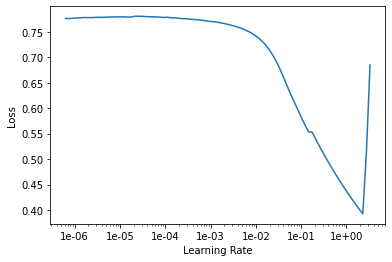

In [ ]:
"""Troviamo il valore di learning rate da utilizzare per l'algoritmo di discesa del gradiente. 
  Prendiamo un valore mediano rispetto al punto di max pendenza """
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.035548,0.023852,0.998800,00:02
1,0.001359,0.002362,0.999600,00:02


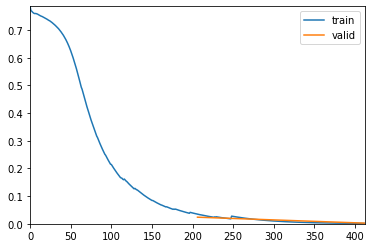

In [ ]:
# Addestramento del modello
learn.fit_one_cycle(2, 1e-02, wd=0.02)

### ***PREDICTION***

In [ ]:
# Valutazione del dataset di test ottenuto splittando il dataset di train
import numpy as np

pred, *_ = learn.get_preds(DatasetType.Test)
label = np.argmax(pred, 1)

y_pred = np.array(label)

In [ ]:
y_pred

array([1, 1, 1, 1, ..., 1, 1, 1, 1])

### ***EVALUATION***

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({1: 15702, 0: 35})
Pred: Counter({1: 15706, 0: 31})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

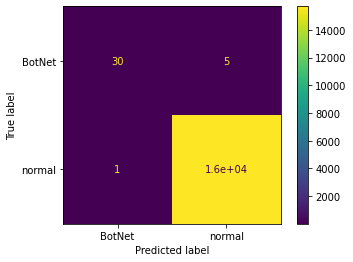

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'BotNet' : 0,
               'normal' : 1}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [   30 15701]
True negative:  [15701    30]
False positive:  [1 5]
False negative:  [5 1]
True positive rate:  [0.857143 0.999936]
True negative rate:  [0.999936 0.857143]
False positive rate:  [6.368615e-05 1.428571e-01]
False negative rate:  [1.428571e-01 6.368615e-05]


In [ ]:
print(cm)

[[   30     5]
 [    1 15701]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91        35
           1       1.00      1.00      1.00     15702

    accuracy                           1.00     15737
   macro avg       0.98      0.93      0.95     15737
weighted avg       1.00      1.00      1.00     15737



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.9996187329224121
Precision_weighted:  0.9996106145479212
Recall_weighted:  0.9996187329224121
mcc:  0.9105814652842887
f2:  0.9996171092369646
